In [47]:
%matplotlib notebook
import numpy as np
import pandas as pd
import random
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model

In [48]:
dataDf = pd.read_csv('data.csv')
x = np.array(dataDf['LATITUDE'].tolist())
y = np.array(dataDf['LONGITUDE'].tolist())
T = np.array(dataDf['ALTITUDE'].tolist())

In [49]:
def normalize(vec, type = 'standardization'):
    
    '''
    Performs normalization on the vector. The type of normalization can be standardization or
    min-max normalization.
    
    Agruments:
        vec: the vector that has to be normalized
        type: 'standardization' or 'min-max'. Default is standardization
        
    Returns:
        vec: the normalized vector
    '''
    
    if type == 'standardization':
        return (vec - np.mean(vec)) / np.std(vec)
    
    if type == 'min-max':
        return (vec - min(vec)) / (max(vec) - min(vec))

In [121]:
def split(x, y, T):
    
    '''
    Splits the vectors into training, cross-validation and test sets,
    following 80%, 10% and 10% sizes respectively.
    
    Arguments:
        x: vector x of data (latitude)
        y: vector y of data (longitude)
        T: target variable vector of data (altitude)
        
    Returns:
        x_train, y_train, T_train, x_val, y_val, T_val, x_test, y_test, T_test
        following the description above
    '''
    
    X = [(x[i], y[i]) for i in range(len(x))]
    X_train, X_test, T_train, T_test = train_test_split(X, T, test_size = 0.2, random_state = 0)
    X_test, X_val, T_test, T_val = train_test_split(X_test, T_test, test_size = 0.5, random_state = 42)
    
    x_test = np.array([X_test[i][0] for i in range(len(X_test))])
    y_test = np.array([X_test[i][1] for i in range(len(X_test))])
    
    x_val = np.array([X_val[i][0] for i in range(len(X_val))])
    y_val = np.array([X_val[i][1] for i in range(len(X_val))])
    
    x_train = np.array([X_train[i][0] for i in range(len(X_train))])
    y_train = np.array([X_train[i][1] for i in range(len(X_train))])
                      
    return x_train, y_train, T_train, x_val, y_val, T_val, x_test, y_test, T_test

In [122]:
def generate_features(x, y, N, deg):
    
    '''
    Generates the feature matrix for each pow of y (dy), get all pow of x (dx), 
    such that dx + dy = deg
    
    The feature matrix looks as:
    
    [[1, x1, x1^2, y1, x1y1, y1^2]
     [1, x2, x2^2, y2, x2y2, y2^2]
      .  .
      .  .
     [1, xN, xN^2, yN, xNyN, yN^2]]
     
     Arguments:
        x: vector x of data (latitude)
        y: vector y of data (longitude)
        N: no. of training examples
        deg: maximum degree upto which features need to be calculated
        
    Returns:
        featureMatrix: the featureMatrix as described
        d: no. of features (no. of columns in featureMatrix)
     '''
    
    featureMatrix = []
    
    # number of features
    d = 0
    
    if N == 1:
        x = [x]
        y = [y]
    
    for n in range(N):
        row = []
        for i in range(deg + 1):
            for j in range(deg - i + 1):
                term = (x[n]**j) * (y[n]**i)
                row.append(term)
                if n == 0:
                    d += 1
        featureMatrix.append(row)
    
    # converting to a numpy array
    featureMatrix = np.array(featureMatrix)
    
    return featureMatrix, d

In [112]:
def update_weights(W, features, error, eta, lamb = 0, reg = 'L2'):
    
    delta = features.dot(error)
    if reg == 'L2':
        delta += lamb*W
    else:
        Wdel = np.copy(W)
        for i in range(len(Wdel)):
            if Wdel[i] > 0:
                Wdel[i] = 1
            if Wdel[i] < 0:
                Wdel[i] = -1
            else:
                Wdel[i] = 0
        delta += lamb*Wdel
    
    W = W - eta*delta
    
    return W

In [55]:
def show(W, error, d):
    
    for i in range(d):
        print(W[i])
    print('Error: ' + str(error) + '\n')

In [56]:
def predict(W, X):
    
    return X.dot(W)

In [113]:
def generate_model(x, y, T, deg, maxIter, eta, lamb = 0, reg = 'L2'):
       
    N = len(x)
    featureMatrix, d = generate_features(x, y, N, deg)
    
    # initial weights vector
    # random initialization
    random.seed(12)
    W = np.array([random.random() for i in range(d)])
    # zero initialization
    # W = np.array([0 for i in range(d)])
    
    prevError = 0
    currentError = 0
    errors = []
    
    for i in tqdm_notebook(range(maxIter)):
        
        H = predict(W, featureMatrix)
        if reg == 'L2':
            E = (0.5*(H - T).dot(np.transpose(H - T))) + (0.5*lamb*sum(W*W))
        else:
            E = (0.5*(H - T).dot(np.transpose(H - T))) + (0.5*lamb*sum((W*W)**0.5))
        prevError = currentError
        currentError = E
        errors.append(currentError)
        #=======
        # Perform termination check here using prevError and currentError
        #=======
        # print(0.5*lamb*sum(W*W))
        # show(W, currentError, d)
        W = update_weights(W, np.transpose(featureMatrix), H - T, eta, lamb, reg)
        
    return W, errors

In [58]:
def generate_stochastic(x, y, T, deg, maxIter, eta, lamb = 0):
    
    random.seed(12)
    featureMatrix, d = generate_features(x[0], y[0], 1, deg)
    W = np.array([random.random() for i in range(d)])
    errors = []
    N = len(T)
    
    for i in range(maxIter):
        
        featureMatrix, d = generate_features(x[i%N], y[i%N], 1, deg)
        H = predict(W, featureMatrix)
        E = (0.5*(H - T[i%N]).dot(np.transpose(H - T[i%N]))) + (0.5*lamb*sum(W*W))
        errors.append(E)
        W = update_weights(W, np.transpose(featureMatrix), H - T[i%N], eta, lamb)
        
    return W, errors

In [59]:
def calc_R2(T, H):
    
    tss = sum((T - np.mean(T))*(T - np.mean(T)))
    rss = sum((T - H)*(T - H))
    
    return 1 - (rss/tss)

In [60]:
def calc_rmse(T, H):
    
    se = sum((T - H)*(T - H))
    mse = se/len(T)
    rmse = mse ** 0.5
    
    return rmse

In [61]:
def plot_loss(errors, numIters, interval):
    
    xLabels = [i for i in range(0, numIters) if i % interval == 0]
    plt.plot(xLabels, [errors[i] for i in range(len(errors)) if i % interval == 0])

In [119]:
def normal_equation(x, y, T, deg):
    
    N = len(x)
    featureMatrix, d = generate_features(x, y, N, deg)
    
    W = np.matmul(np.transpose(featureMatrix), featureMatrix)
    W = np.linalg.inv(W)
    W = np.matmul(W, np.transpose(featureMatrix))
    W = np.dot(W, T)
    
    return W

In [164]:
def get_best_lambda(x, y, T):
    
    x_train, y_train, T_train, x_val, y_val, T_val, x_test, y_test, T_test = split(x, y, T)
    
    W = np.array([])
    curr_lambda = 0
    
    l = 0
    r = 1000
    numIters = 1000
    cnt = 0
    
    lambdas = []
    rmses = []
    
    while l <= r and cnt < 25:
        
        curr_lambda = (l + r) / 2
        W, errors = generate_model(x_train, y_train, T_train, 1, numIters, 0.0000003, curr_lambda, 'L2')
        X, num = generate_features(x_val, y_val, len(x_val), 1)
        H = predict(W, X)
        rmse = calc_rmse(T_val, H)
        lambdas.append(curr_lambda)
        rmses.append(rmse)
        
        W1, errors = generate_model(x_train, y_train, T_train, 1, numIters, 0.0000003, curr_lambda+0.01*curr_lambda, 'L2')
        X, num = generate_features(x_val, y_val, len(x_val), 1)
        H = predict(W1, X)
        rmse1 = calc_rmse(T_val, H)
        W2, errors = generate_model(x_train, y_train, T_train, 1, numIters, 0.0000003, curr_lambda-0.01*curr_lambda, 'L2')
        X, num = generate_features(x_val, y_val, len(x_val), 1)
        H = predict(W2, X)
        rmse2 = calc_rmse(T_val, H)
        
        if rmse < rmse1 and rmse < rmse2:
            break
            
        elif rmse < rmse1 and rmse > rmse2:
            r = curr_lambda
            
        elif rmse > rmse1 and rmse < rmse2:
            l = curr_lambda
            
        cnt += 1
        print(cnt)
        
    X, num = generate_features(x_test, y_test, len(x_test), 1)
    H = predict(W, X)
    print('R2 error: ', calc_R2(T_test, H))    
    print('RMS error: ', calc_rmse(T_test, H))
    
    return W, curr_lambda, lambdas, rmses

In [62]:
def scikit_regression(x, y, T):
    
    data = [[x[i],y[i]] for i in range(len(x))]
    reg = linear_model.LinearRegression()
    reg.fit(data, T)
    return np.concatenate((np.array([reg.intercept_]),reg.coef_))

In [63]:
normalizedx = normalize(x)
normalizedy = normalize(y)
normalizedT = normalize(T)

In [165]:
# x_train, y_train, T_train, x_val, y_val, T_val, x_test, y_test, T_test = split(x, y, T)
x_train, y_train, T_train, x_val, y_val, T_val, x_test, y_test, T_test = split(normalizedx, normalizedy, T)
# x_train, y_train, T_train = normalizedx, normalizedy, normalizedT
# x_train, y_train, T_train = x, y, T

# for i in range(1,2):
#     print('For degree ', i)
#     numIters = 1000
#     # W, errors = generate_model(x_train, y_train, T_train, i, numIters, 0.0000003, 1, 'L1')
#     # W, errors = generate_model(x_train, y_train, T_train, i, numIters, 0.0000003, 1, 'L2')
#     # print('Final loss: ', errors[len(errors) - 1])
#     # plot_loss(errors, numIters, 20)
#     W = normal_equation(x_train, y_train, T_train, 1)
#     X, num = generate_features(x_val, y_val, len(x_val), i)
#     H = predict(W, X)
#     print('R2 error: ', calc_R2(T_val, H))    
#     print('RMS error: ', calc_rmse(T_val, H))
#     print(W)
#     print(scikit_regression(x_train, y_train, T_train))
#     print('\n\n')

best_model, best_lambda, lambdas, rmses = get_best_lambda(normalizedx, normalizedy, T)
# plt.plot(lambdas, rmses)

# print(scikit_regression(x_train, y_train, T_train))
# W, errors = generate_stochastic(x_train, y_train, T_train, 1, len(x_train)//2, 0.03)
# print(W)
# W, errors = generate_stochastic(x_train, y_train, T_train, 1, len(x_train), 0.03)
# print(W)
# W, errors = generate_stochastic(x_train, y_train, T_train, 1, len(x_train)*2, 0.03)
# print(W)
# W, errors = generate_stochastic(x_train, y_train, T_train, 1, len(x_train)*4, 0.03)
# print(W)


1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25
R2 error:  0.027697608999357026
RMS error:  18.603338974554326


<IPython.core.display.Javascript object>


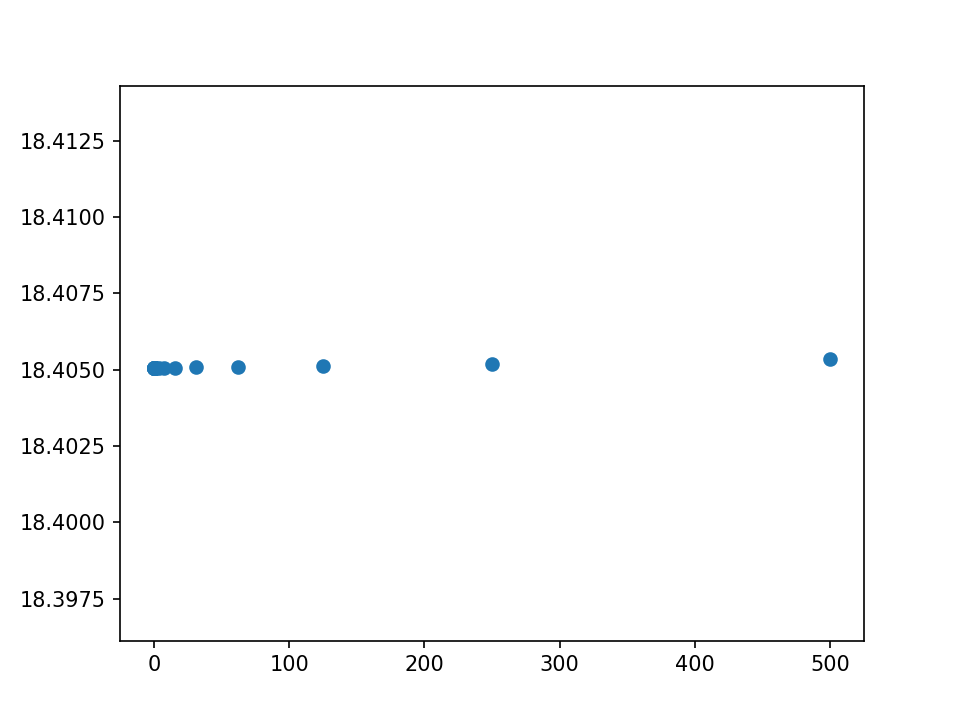

2.9802322387695312e-05


In [168]:
# ax.set_yticks(np.arange(min(y), max(y)+1, 1.0))
plt.scatter(lambdas, rmses)
print(best_lambda)

# Unnormalized

## Degree = 2
### Max iterations = 10,000
### eta = 0.0000000000001

0.4744234599520871      1 <br>
0.6474382918705535      x <br>
0.0005804929584987999   x^2 <br>
0.14105769027351664     y <br>
-0.09403124677459616    xy <br>
0.3544625440157649      y^2 <br>

Error:  75436974.66365339

---------------------------------------------------

## Degree = 1
### Max iterations = 10,000
### eta = 0.000000001

0.5185508389987425       1 <br>
0.15099146093306134      x <br>
1.3394518499352581       y <br>

Error:  75282294.06572284

---
---

# Normalized

## Degree = 2
### Max iterations = 1,000
### eta = 0.000002

0.15263109107088374 1 <br>
-0.046585920675156704 x <br>
0.21581304287314088 x^2 <br>
0.3174109858230444 y <br>
-0.39821638060691267 xy <br>
-0.1120204638382443 y^2 <br>

Error: 3492.6023185812373

---------------------------------------------------

## Degree = 1
### Max iterations = 1,000
### eta = 0.000002

0.20875515071358333      1 <br>
-0.10010713951478299     x <br>
0.09525453491739086      y <br>

Error: 3585.734618153786